In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import datetime as dt

from pybaseball import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import psycopg2
import pandas.io.sql as psql
from sqlalchemy import create_engine

from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)


In [25]:
df_18 = pd.read_pickle('../pickles/2018_games_labeled_1.pkl')
df_17 = pd.read_pickle('../pickles/2017_games_labeled_1.pkl')
df_16 = pd.read_pickle('../pickles/2016_games_labeled_1.pkl')
df_15 = pd.read_pickle('../pickles/2015_games_labeled_1.pkl')
merge = pd.read_pickle('../pickles/labeled_games_agg.pkl')
total = pd.read_pickle('../pickles/labeled_games_agg_sc_hist.pkl')

In [26]:
df_18.head()

,#days,2b,3b,ab,age,appearance_yr,babip,bb,bf,cs,date,days,days_preceeding,days_rest,enddate,er,era,first_x,first_y,g,gb/fb,gdp,gs,h,hbp,hr,ibb,injured?,injury,ip,key_bbref_x,key_bbref_y,key_fangraphs_x,key_fangraphs_y,key_mlbam,key_retro_x,key_retro_y,l,last_x,last_y,ld,lev,list,mlb_played_first_x,mlb_played_first_y,mlb_played_last_x,mlb_played_last_y,moneyearned,name_first_x,name_first_y,name_last_x,name_last_y,name_x,name_y,pit,po,posititon,pu,r,sb,sf,so,so/w,so9,startdate,stl,str,sts,sv,team,tm,w,whip,year
95,368.0,0.0,0.0,23.0,45.0,1,0.333,1.0,24.0,0.0,2018-04-02,9.0,144,182.0,9/1,1.0,1.50,bartolocolon,bartolo,1.0,0.55,1.0,1.0,7.0,0.0,1.0,0.0,0.0,Back,6.0,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.10,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,89.0,0.0,SP,0.05,1.0,0.0,0.0,4.0,4.0,6.0,2018-08-24,0.21,0.70,0.07,NaN,TEX,Texas,NaN,1.333,2018.0
96,362.0,0.0,0.0,7.0,45.0,2,0.333,0.0,7.0,0.0,2018-04-08,9.0,138,6.0,9/1,0.0,0.00,bartolocolon,bartolo,1.0,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Back,2.0,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.00,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,29.0,0.0,SP,0.00,0.0,0.0,0.0,4.0,NaN,18.0,2018-08-24,0.24,0.72,0.14,NaN,TEX,Texas,NaN,0.500,2018.0
97,360.0,0.0,0.0,9.0,45.0,3,0.250,0.0,10.0,0.0,2018-04-10,9.0,136,2.0,9/1,1.0,3.00,bartolocolon,bartolo,1.0,0.38,0.0,0.0,2.0,0.0,0.0,0.0,0.0,Back,3.0,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.25,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,29.0,0.0,SP,0.00,1.0,0.0,1.0,2.0,NaN,6.0,2018-08-24,0.14,0.66,0.10,NaN,TEX,Texas,NaN,0.667,2018.0
98,355.0,1.0,0.0,23.0,45.0,4,0.059,1.0,25.0,0.0,2018-04-15,9.0,131,5.0,9/1,1.0,1.17,bartolocolon,bartolo,1.0,0.59,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Back,7.2,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.18,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,96.0,0.0,SP,0.00,1.0,0.0,1.0,7.0,7.0,8.2,2018-08-24,0.24,0.69,0.08,NaN,TEX,Texas,NaN,0.261,2018.0
99,349.0,0.0,0.0,22.0,45.0,5,0.300,1.0,25.0,1.0,2018-04-21,9.0,125,6.0,9/1,4.0,6.35,bartolocolon,bartolo,1.0,0.52,0.0,1.0,7.0,1.0,1.0,0.0,0.0,Back,5.2,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.24,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,85.0,0.0,SP,0.00,4.0,0.0,1.0,2.0,2.0,3.2,2018-08-24,0.21,0.69,0.08,NaN,TEX,Texas,NaN,1.412,2018.0


In [27]:
# sc_18 = pd.read_pickle('../pickles/sc_2018_unclean.pkl')
# sc_17 = pd.read_pickle('../pickles/sc_2017_unclean.pkl')
# sc_16 = pd.read_pickle('../pickles/sc_2016_unclean.pkl')
# sc_15 = pd.read_pickle('../pickles/sc_2015_unclean.pkl')
# total = sc_18.append([sc_17, sc_16, sc_15])
# total = total.sort_values(by=['key_mlbam', 'date'])
# total = total.set_index(np.arange(len(total)))
# total.to_pickle('../pickles/labeled_games_agg_sc.pkl')

In [28]:
drop = ['#days', '2b', '3b', 'ab', 'cs', 'date', 'days', 'days_preceeding', 'enddate', 'era', 'first_x', 'first_y', 'g', 'gdp', 'gs', 'ibb', 'injury', 'key_bbref_x', 'key_bbref_y', 'key_fangraphs_x', 'key_fangraphs_y', 'key_mlbam', 'key_retro_x', 'key_retro_y', 'l', 'last_x', 'last_y', 'ld', 'lev', 'list', 'mlb_played_first_y', 'mlb_played_last_x', 'mlb_played_last_y', 'moneyearned', 'name_first_x', 'name_first_y', 'name_last_x', 'name_last_y', 'name_x', 'name_y', 'po', 'posititon', 'pu', 'sb', 'sf', 'so/w', 'startdate', 'stl', 'sts', 'sv', 'team', 'tm', 'year']

In [29]:
# X = total.drop(columns=drop)
# X = X.replace([np.inf, -np.inf], np.nan)
# X

In [30]:
# X = X[X['fb_count'].notnull() | X['os_count'].notnull()]
# X['w'] = X['w'].fillna(0)
# X

In [31]:
# len(X[X['p_throws_x'].isnull() & X['p_throws_y'].isnull()])

In [32]:

X = total.drop(columns=drop)
X = X.replace([np.inf, -np.inf], np.nan)
X = X[X['fb_count'].notnull() | X['os_count'].notnull()]
X['p_throws_x'] = X['p_throws_x'].fillna(X['p_throws_y'])
X = X.drop(columns='p_throws_y')
X['fb_count'] = X['fb_count']/X['pit']
X['os_count'] = X['os_count']/X['pit']
X = X.fillna(0)


In [33]:
# X.to_pickle('../pickles/X_ugly.pkl')
# X = pd.read_pickle('../pickles/X_ugly.pkl')
idk = X.columns.tolist()
idk

['age',
 'appearance_yr',
 'babip',
 'bb',
 'bf',
 'days_rest',
 'er',
 'gb/fb',
 'h',
 'hbp',
 'hr',
 'injured?',
 'ip',
 'mlb_played_first_x',
 'pit',
 'r',
 'so',
 'so9',
 'str',
 'w',
 'whip',
 'fb_count',
 'p_throws_x',
 'fb_release_speed',
 'fb_percieved_speed',
 'fb_spin_rate',
 'fb_avg_x',
 'fb_avg_z',
 'fb_avg_extension',
 'fb_x_movement',
 'fb_z_movement',
 'os_count',
 'os_release_speed',
 'os_percieved_speed',
 'os_spin_rate',
 'os_avg_x',
 'os_avg_z',
 'os_avg_extension',
 'os_x_movement',
 'os_z_movement',
 'hist_fb_count',
 'hist_fb_release_speed',
 'hist_fb_percieved_speed',
 'hist_fb_spin_rate',
 'hist_fb_avg_x',
 'hist_fb_avg_z',
 'hist_fb_avg_extension',
 'hist_fb_x_movement',
 'hist_fb_z_movement',
 'hist_os_count',
 'hist_os_release_speed',
 'hist_os_percieved_speed',
 'hist_os_spin_rate',
 'hist_os_avg_x',
 'hist_os_avg_z',
 'hist_os_avg_extension',
 'hist_os_x_movement',
 'hist_os_z_movement']

In [34]:
X['delta_fb_release_speed'] = X['hist_fb_release_speed'] - X['fb_release_speed']
X['delta_fb_percieved_speed'] = X['hist_fb_percieved_speed'] - X['fb_percieved_speed']
X['delta_fb_spin_rate'] = X['hist_fb_spin_rate'] - X['fb_spin_rate']
X['delta_fb_avg_x'] = X['hist_fb_avg_x'] - X['fb_avg_x']
X['delta_fb_avg_z'] = X['hist_fb_avg_z'] - X['fb_avg_z']
X['delta_fb_avg_extension'] = X['hist_fb_avg_extension'] - X['fb_avg_extension']
X['delta_fb_x_movement'] = X['hist_fb_x_movement'] - X['fb_x_movement']
X['delta_fb_z_movement'] = X['hist_fb_z_movement'] - X['fb_z_movement']
X['delta_os_release_speed'] = X['hist_os_release_speed'] - X['os_release_speed']
X['delta_os_percieved_speed'] = X['hist_os_percieved_speed'] - X['os_percieved_speed']
X['delta_os_spin_rate'] = X['hist_os_spin_rate'] - X['os_spin_rate']
X['delta_os_avg_x'] = X['hist_os_avg_x'] - X['os_avg_x']
X['delta_os_avg_z'] = X['hist_os_avg_z'] - X['os_avg_z']
X['delta_os_avg_extension'] = X['hist_os_avg_extension'] - X['os_avg_extension']
X['delta_os_x_movement'] = X['hist_os_x_movement'] - X['os_x_movement']
X['delta_os_z_movement'] = X['hist_os_z_movement'] - X['os_z_movement']
X['hist_fb_count'] = X['hist_fb_count'] / (X['hist_fb_count'] + X['hist_os_count'])
X['hist_os_count'] = 1 - X['hist_fb_count']

In [37]:
X['delta_fb_count'] = X['hist_fb_count'] - X['fb_count']
X['delta_os_count'] = X['hist_os_count'] - X['os_count']

In [35]:
X = X[X['fb_count'] != 0]
X = X[X['os_count'] != 0]

In [39]:
ok = ['hist_fb_count',
 'hist_fb_release_speed',
 'hist_fb_percieved_speed',
 'hist_fb_spin_rate',
 'hist_fb_avg_x',
 'hist_fb_avg_z',
 'hist_fb_avg_extension',
 'hist_fb_x_movement',
 'hist_fb_z_movement',
 'hist_os_count',
 'hist_os_release_speed',
 'hist_os_percieved_speed',
 'hist_os_spin_rate',
 'hist_os_avg_x',
 'hist_os_avg_z',
 'hist_os_avg_extension',
 'hist_os_x_movement',
 'hist_os_z_movement']

In [40]:
X = X.drop(columns=ok)

In [41]:
X

,age,appearance_yr,babip,bb,bf,days_rest,er,gb/fb,h,hbp,hr,injured?,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,p_throws_x,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,delta_fb_release_speed,delta_fb_percieved_speed,delta_fb_spin_rate,delta_fb_avg_x,delta_fb_avg_z,delta_fb_avg_extension,delta_fb_x_movement,delta_fb_z_movement,delta_os_release_speed,delta_os_percieved_speed,delta_os_spin_rate,delta_os_avg_x,delta_os_avg_z,delta_os_avg_extension,delta_os_x_movement,delta_os_z_movement,delta_fb_count,delta_os_count
0,42.0,1,0.154,1.0,23.0,182.0,1.0,0.64,3.0,0.0,1.0,0.0,6.0,1997.0,86.0,1.0,8.0,12.0,0.69,1.0,0.667,0.883721,R,89.784211,88.202553,2280.710526,-1.481718,5.916537,5.605737,-1.026215,1.276848,0.116279,83.540000,81.596556,2469.444444,-1.733989,5.992122,5.262667,0.046602,0.628567,-1.571627,-1.937016,-132.305477,0.150396,-0.208972,-0.343583,-0.177165,-0.278786,-1.754849,-1.646236,-489.325658,0.266443,-0.326211,-0.135806,-0.543012,0.007690,-0.043328,0.043328
1,42.0,2,0.238,0.0,27.0,6.0,3.0,0.33,6.0,0.0,1.0,0.0,7.0,1997.0,77.0,3.0,5.0,6.4,0.78,1.0,0.857,0.922078,R,88.569014,86.327366,2133.971831,-1.161156,5.956703,5.049437,-0.843298,1.237249,0.077922,82.000000,80.086500,1761.833333,-1.357450,6.000083,4.996000,-0.546108,0.733678,-0.356431,-0.061829,14.433219,-0.170166,-0.249138,0.212717,-0.360082,-0.239186,-0.214849,-0.136181,218.285453,-0.110096,-0.334173,0.130860,0.049698,-0.097421,-0.081685,0.081685
2,42.0,3,0.250,0.0,26.0,5.0,1.0,0.43,6.0,0.0,1.0,0.0,7.0,1997.0,91.0,1.0,5.0,6.4,0.73,1.0,0.857,0.835165,R,89.246053,87.101987,2193.346667,-1.295146,6.124792,5.372947,-1.087467,1.038179,0.164835,82.940000,80.848267,1817.461538,-1.520147,6.105167,5.204200,-0.449991,0.594358,-1.033469,-0.836450,-44.941617,-0.036176,-0.417227,-0.110793,-0.115913,-0.040117,-1.154849,-0.897947,162.657248,0.052600,-0.439256,-0.077340,-0.046419,0.041899,0.005228,-0.005228
3,42.0,4,0.368,0.0,24.0,6.0,3.0,0.22,7.0,0.0,0.0,0.0,6.0,1997.0,88.0,3.0,5.0,7.5,0.66,1.0,1.167,0.909091,R,89.025000,86.779882,2196.473684,-1.227378,6.096868,5.243171,-1.292720,1.116850,0.125000,81.936364,79.716000,2036.363636,-1.438264,6.180809,5.089818,-0.711843,0.584264,-0.812417,-0.514345,-48.068634,-0.103944,-0.389303,0.018983,0.089340,-0.118787,-0.151213,0.234319,-56.244850,-0.029283,-0.514898,0.037042,0.215433,0.051993,-0.068698,0.034607
4,42.0,5,0.333,0.0,29.0,6.0,4.0,0.48,9.0,0.0,1.0,0.0,6.2,1997.0,91.0,4.0,2.0,2.7,0.70,0.0,1.350,0.791209,R,88.462500,86.099380,2192.563380,-0.902362,6.524101,5.158310,-1.210262,1.227521,0.186813,82.476471,79.931938,2331.312500,-1.208682,6.446600,4.900688,-0.017521,0.677131,-0.249917,0.166157,-44.158330,-0.428959,-0.816536,0.103844,0.006882,-0.229458,-0.691320,0.018382,-351.193714,-0.258864,-0.780689,0.226173,-0.478889,-0.040875,0.049184,-0.027206
5,42.0,6,0.263,0.0,29.0,6.0,1.0,0.30,6.0,0.0,1.0,0.0,7.2,1997.0,97.0,1.0,9.0,10.6,0.73,1.0,0.783,0.773196,R,88.473333,86.168562,2127.808219,-1.324715,6.090521,5.345877,-1.258029,0.782793,0.226804,82.859091,80.577182,2202.272727,-1.462559,6.199268,5.153591,-0.258982,0.475265,-0.260750,0.096975,20.596831,-0.006607,-0.382956,-0.083723,0.054649,0.215269,-1.073940,-0.626863,-222.153941,-0.004987,-0.533357,-0.026731,-0.237428,0.160991,0.067197,-0.067197
6,42.0,7,0.368,0.0,26.0,5.0,4.0,0.35,8.0,0.0,1.0,0.0,6.0,1997.0,92.0,4.0,6.0,9.0,0.75,1.0,1.333,0.858696,R,89.063291,87.144241,2178.227848,-1.085206,6.025118,5.298582,-1.327961,1.177207,0.141304,81.961538,79.916769,2060.400000,-1.185146,6.063846,5.134154,-0.592354,0.733200,-0.850708,-0.878704,-29.822798,-0.246116,-0.317553,-0.036428,0.124581,-0.179144,-0.176388,0.033550,-80.281214,-0.282400,-0.397935,-0.007294,0.095945,-0.096943,-0.018303,0.018303
7,42.0,8,0.263,0.0,23.0,5.0,5.0,0.48,7.0,0.0,2.0,0.0,5.0,1997.0,62.0,6.0,2.0,3.6,0.84,0.0,1.400,0.854839,R,88.739623,86

In [42]:
dummies = pd.get_dummies(X['p_throws_x'])
dummies

,L,R
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1
7,0,1
8,0,1
9,0,1


In [43]:
X = pd.concat([X, dummies], axis=1)

In [44]:
X = X.drop(columns='p_throws_x')
# X['fb_count'] = X['fb_count']/X['pit']
# X['os_count'] = X['os_count']/X['pit']
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

In [45]:
y = X.pop('injured?')

In [46]:
X

,age,appearance_yr,babip,bb,bf,days_rest,er,gb/fb,h,hbp,hr,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,delta_fb_release_speed,delta_fb_percieved_speed,delta_fb_spin_rate,delta_fb_avg_x,delta_fb_avg_z,delta_fb_avg_extension,delta_fb_x_movement,delta_fb_z_movement,delta_os_release_speed,delta_os_percieved_speed,delta_os_spin_rate,delta_os_avg_x,delta_os_avg_z,delta_os_avg_extension,delta_os_x_movement,delta_os_z_movement,delta_fb_count,delta_os_count,L,R
0,42.0,1,0.154,1.0,23.0,182.0,1.0,0.64,3.0,0.0,1.0,6.0,1997.0,86.0,1.0,8.0,12.0,0.69,1.0,0.667,0.883721,89.784211,88.202553,2280.710526,-1.481718,5.916537,5.605737,-1.026215,1.276848,0.116279,83.540000,81.596556,2469.444444,-1.733989,5.992122,5.262667,0.046602,0.628567,-1.571627,-1.937016,-132.305477,0.150396,-0.208972,-0.343583,-0.177165,-0.278786,-1.754849,-1.646236,-489.325658,0.266443,-0.326211,-0.135806,-0.543012,0.007690,-0.043328,0.043328,0,1
1,42.0,2,0.238,0.0,27.0,6.0,3.0,0.33,6.0,0.0,1.0,7.0,1997.0,77.0,3.0,5.0,6.4,0.78,1.0,0.857,0.922078,88.569014,86.327366,2133.971831,-1.161156,5.956703,5.049437,-0.843298,1.237249,0.077922,82.000000,80.086500,1761.833333,-1.357450,6.000083,4.996000,-0.546108,0.733678,-0.356431,-0.061829,14.433219,-0.170166,-0.249138,0.212717,-0.360082,-0.239186,-0.214849,-0.136181,218.285453,-0.110096,-0.334173,0.130860,0.049698,-0.097421,-0.081685,0.081685,0,1
2,42.0,3,0.250,0.0,26.0,5.0,1.0,0.43,6.0,0.0,1.0,7.0,1997.0,91.0,1.0,5.0,6.4,0.73,1.0,0.857,0.835165,89.246053,87.101987,2193.346667,-1.295146,6.124792,5.372947,-1.087467,1.038179,0.164835,82.940000,80.848267,1817.461538,-1.520147,6.105167,5.204200,-0.449991,0.594358,-1.033469,-0.836450,-44.941617,-0.036176,-0.417227,-0.110793,-0.115913,-0.040117,-1.154849,-0.897947,162.657248,0.052600,-0.439256,-0.077340,-0.046419,0.041899,0.005228,-0.005228,0,1
3,42.0,4,0.368,0.0,24.0,6.0,3.0,0.22,7.0,0.0,0.0,6.0,1997.0,88.0,3.0,5.0,7.5,0.66,1.0,1.167,0.909091,89.025000,86.779882,2196.473684,-1.227378,6.096868,5.243171,-1.292720,1.116850,0.125000,81.936364,79.716000,2036.363636,-1.438264,6.180809,5.089818,-0.711843,0.584264,-0.812417,-0.514345,-48.068634,-0.103944,-0.389303,0.018983,0.089340,-0.118787,-0.151213,0.234319,-56.244850,-0.029283,-0.514898,0.037042,0.215433,0.051993,-0.068698,0.034607,0,1
4,42.0,5,0.333,0.0,29.0,6.0,4.0,0.48,9.0,0.0,1.0,6.2,1997.0,91.0,4.0,2.0,2.7,0.70,0.0,1.350,0.791209,88.462500,86.099380,2192.563380,-0.902362,6.524101,5.158310,-1.210262,1.227521,0.186813,82.476471,79.931938,2331.312500,-1.208682,6.446600,4.900688,-0.017521,0.677131,-0.249917,0.166157,-44.158330,-0.428959,-0.816536,0.103844,0.006882,-0.229458,-0.691320,0.018382,-351.193714,-0.258864,-0.780689,0.226173,-0.478889,-0.040875,0.049184,-0.027206,0,1
5,42.0,6,0.263,0.0,29.0,6.0,1.0,0.30,6.0,0.0,1.0,7.2,1997.0,97.0,1.0,9.0,10.6,0.73,1.0,0.783,0.773196,88.473333,86.168562,2127.808219,-1.324715,6.090521,5.345877,-1.258029,0.782793,0.226804,82.859091,80.577182,2202.272727,-1.462559,6.199268,5.153591,-0.258982,0.475265,-0.260750,0.096975,20.596831,-0.006607,-0.382956,-0.083723,0.054649,0.215269,-1.073940,-0.626863,-222.153941,-0.004987,-0.533357,-0.026731,-0.237428,0.160991,0.067197,-0.067197,0,1
6,42.0,7,0.368,0.0,26.0,5.0,4.0,0.35,8.0,0.0,1.0,6.0,1997.0,92.0,4.0,6.0,9.0,0.75,1.0,1.333,0.858696,89.063291,87.144241,2178.227848,-1.085206,6.025118,5.298582,-1.327961,1.177207,0.141304,81.961538,79.916769,2060.400000,-1.185146,6.063846,5.134154,-0.592354,0.733200,-0.850708,-0.878704,-29.822798,-0.246116,-0.317553,-0.036428,0.124581,-0.179144,-0.176388,0.033550,-80.281214,-0.282400,-0.397935,-0.007294,0.095945,-0.096943,-0.018303,0.018303,0,1
7,42.0,8,0.263,0.0,23.0,5.0,5.0,0.48,7.0,0.0,2.0,5.0,1997.0,62.0,6.0,2.0,3.6,0.84,0.0,1.400,0.854839,88.739623,86.634673,2157.230769,-1.302373,6.0499

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, random_state=42)

In [50]:
from imblearn.over_sampling import SMOTE

In [51]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(3, 12, 10),
    'class_weight': ['balanced']
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, scoring='f1_weighted', cv=6, verbose=5, n_jobs=-1)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 6 folds for each of 10 candidates, totalling 60 fits
[CV] C=3.0, class_weight=balanced ....................................
[CV] C=3.0, class_weight=balanced ....................................
[CV] C=3.0, class_weight=balanced ....................................
[CV] C=3.0, class_weight=balanced ....................................
[CV] C=3.0, class_weight=balanced ....................................
[CV] C=3.0, class_weight=balanced ....................................
[CV] C=4.0, class_weight=balanced ....................................
[CV] C=4.0, class_weight=balanced ....................................
[CV] C=4.0, class_weight=balanced ....................................
[CV] C=4.0, class_weight=balanced ....................................
[CV] C=4.0, class_weight=balanced ....................................
[CV] C=4.0, class_weight=balanced ....................................


KeyboardInterrupt: 

In [58]:
clf.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [59]:
lr1 = LogisticRegression(C=5, class_weight='balanced', n_jobs=-1, verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=5, warm_start=False)

In [60]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 66.97247706422019%
Precision metric in the train dataset: 99.49783791323755%
Accuracy metric in the train dataset: 69.35247921157992%


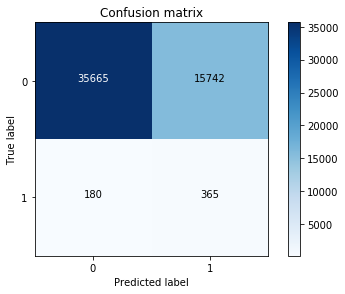

In [61]:
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
print("Precision metric in the train dataset: {}%".format(100*cnf_matrix_tra[0,0]/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,0])))
print("Accuracy metric in the train dataset: {}%".format(100*(cnf_matrix_tra[0,0] + cnf_matrix_tra[1,1])/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,1]+cnf_matrix_tra[0,1]+cnf_matrix_tra[1,0])))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 62.666666666666664%
Precision metric in the testing dataset: 99.36435868331442%
Accuracy metric in the testing dataset: 69.15471491656571%


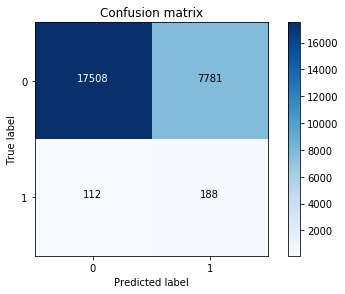

In [62]:
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
print("Accuracy metric in the testing dataset: {}%".format(100*(cnf_matrix[0,0] + cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[0,1]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [63]:
# tmp = lr1.fit(X_train_res, y_train_res.ravel())

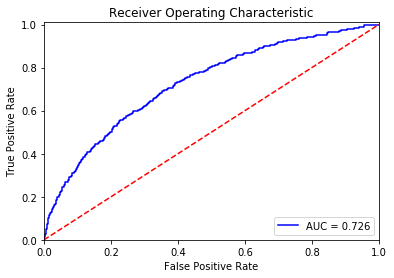

In [64]:
y_pred_sample_score = lr1.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
scaler = StandardScaler()

In [48]:
X_std = scaler.fit_transform(X)

In [150]:
# rf = RandomForestClassifier(n_estimators = 300, class_weight='balanced', n_jobs=-1, oob_score=True, max_depth=3, max_features=3)
rf = RandomForestClassifier(n_estimators = 300, class_weight='balanced', n_jobs=-1, oob_score=True, max_depth=7, max_features=3)

In [151]:
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features=3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [152]:
y_pred = rf.predict(X_test)

In [153]:
print(len(X_train_res))
print(len(y_train_res))
y_pred.sum()

102814
102814


4977.0

Recall metric in the train dataset: 66.78899082568807%
Precision metric in the training dataset: 99.56735825604743%
Accuracy metric in the training dataset: 80.88042808746535%


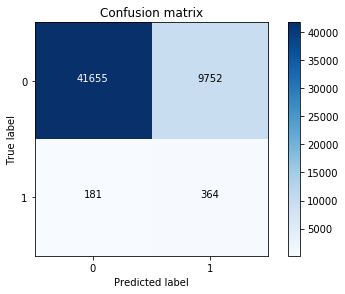

In [154]:
y_train_pre = rf.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
print("Precision metric in the training dataset: {}%".format(100*cnf_matrix_tra[0,0]/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,0])))
print("Accuracy metric in the training dataset: {}%".format(100*(cnf_matrix_tra[0,0] + cnf_matrix_tra[1,1])/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,1]+cnf_matrix_tra[0,1]+cnf_matrix_tra[1,0])))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 47.666666666666664%
Precision metric in the testing dataset: 99.23830778187464%
Accuracy metric in the testing dataset: 80.49552542107936%


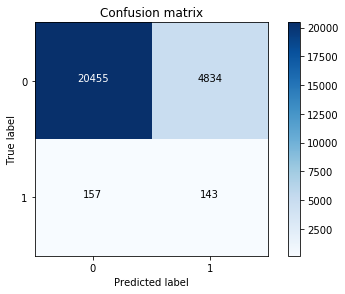

In [155]:
# y_pred = rf.predict(X_test)

cnf_matrix_rf = confusion_matrix(y_test, y_pred)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix_rf[1,1]/(cnf_matrix_rf[1,0]+cnf_matrix_rf[1,1])))
print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix_rf[0,0]/(cnf_matrix_rf[0,0]+cnf_matrix_rf[1,0])))
print("Accuracy metric in the testing dataset: {}%".format(100*(cnf_matrix_rf[0,0] + cnf_matrix_rf[1,1])/(cnf_matrix_rf[0,0]+cnf_matrix_rf[1,1]+cnf_matrix_rf[0,1]+cnf_matrix_rf[1,0])))
# {tp+tn}/{tp+tn+fp+fn}}
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rf , classes=class_names, title='Confusion matrix')
plt.show()

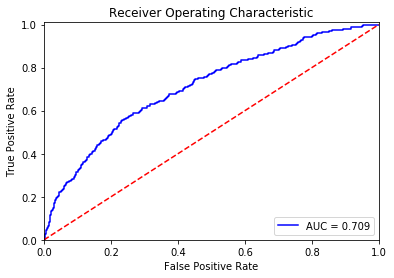

In [156]:
y_pred_sample_score_rf = rf.predict_proba(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score_rf[:, 1])

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [135]:
rf.predict_proba(X_test)[:, 1]

array([0.44563437, 0.33678893, 0.13904951, ..., 0.30302931, 0.34810897,
       0.61870206])

In [213]:
param_grid = {
    'max_depth': [2, 3, 5],
    'max_features': [2, 3, 'auto', 'sqrt'],
    
}

rf2 = RandomForestClassifier(n_estimators = 300, class_weight='balanced')
clf2 = GridSearchCV(rf2, param_grid, scoring='recall_weighted', cv=5, verbose=5, n_jobs=-1)
clf2.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=auto ..................................
[CV] max_depth=2, max_features=auto ..................................
[CV]  max_depth=2, max_features=2, score=0.7753584705257568, total=  34.1s
[CV] max_dep

[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:  6.3min remaining:  1.3min


[CV]  max_depth=5, max_features=auto, score=0.8700654983182864, total= 2.7min
[CV]  max_depth=5, max_features=auto, score=0.8813506815365552, total= 2.6min
[CV]  max_depth=5, max_features=auto, score=0.8818270337257679, total= 2.5min
[CV]  max_depth=5, max_features=auto, score=0.8842613083119413, total= 2.5min
[CV]  max_depth=5, max_features=auto, score=0.8810746215809507, total= 2.4min
[CV]  max_depth=5, max_features=sqrt, score=0.8700654983182864, total= 2.4min
[CV]  max_depth=5, max_features=sqrt, score=0.8813506815365552, total= 2.4min
[CV]  max_depth=5, max_features=sqrt, score=0.8818270337257679, total= 2.2min
[CV]  max_depth=5, max_features=sqrt, score=0.8810746215809507, total= 2.2min
[CV]  max_depth=5, max_features=sqrt, score=0.8842613083119413, total= 2.2min


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 5], 'max_features': [2, 3, 'auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall_weighted', verbose=5)

In [214]:
clf2.best_params_

{'max_depth': 5, 'max_features': 'auto'}

In [119]:
rf.oob_score_

0.9161398253156186

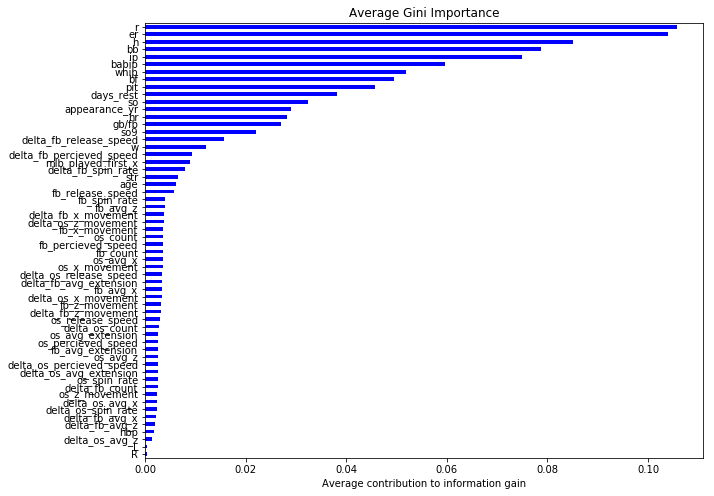

In [120]:
feat_scores = pd.Series(rf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

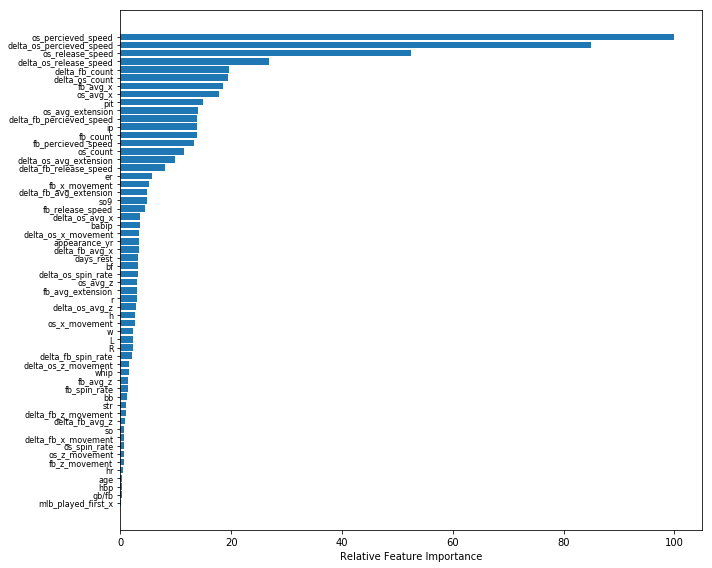

In [75]:
feature_importance = abs(lr1.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,8))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [146]:
drop

['#days',
 '2b',
 '3b',
 'ab',
 'babip',
 'bf',
 'cs',
 'date',
 'days',
 'days_preceeding',
 'enddate',
 'era',
 'first_x',
 'first_y',
 'g',
 'gb/fb',
 'gdp',
 'gs',
 'ibb',
 'injury',
 'key_bbref_x',
 'key_bbref_y',
 'key_fangraphs_x',
 'key_fangraphs_y',
 'key_mlbam',
 'key_retro_x',
 'key_retro_y',
 'l',
 'last_x',
 'last_y',
 'ld',
 'lev',
 'list',
 'mlb_played_first_y',
 'mlb_played_last_x',
 'mlb_played_last_y',
 'moneyearned',
 'name_first_x',
 'name_first_y',
 'name_last_x',
 'name_last_y',
 'name_x',
 'name_y',
 'po',
 'posititon',
 'pu',
 'sb',
 'sf',
 'so/w',
 'startdate',
 'stl',
 'sts',
 'sv',
 'team',
 'tm',
 'year']

In [232]:
# pro = total.drop(columns=drop)
drop_more = ['L', 'R', 'appearance_yr', 'ip', 'mlb_played_first_x', 'w', 'fb_percieved_speed', 'fb_avg_x', 'os_percieved_speed', 'os_avg_x']

pro = X
# pro = pro.replace([np.inf, -np.inf], np.nan)
# pro['p_throws_x'] = pro['p_throws_x'].fillna(pro['p_throws_y'])
# pro = pro.drop(columns='p_throws_y')
# pro = pro.fillna(0)
pro = pro.drop(columns=drop_more)

In [148]:
pro['fb_count'] = pro['fb_count']/pro['pit']

In [149]:
pro['os_count'] = pro['os_count']/pro['pit']

In [150]:
pro = pro.replace([np.inf, -np.inf], np.nan)
pro = pro.fillna(0)

In [233]:
pro

,age,bb,days_rest,er,h,hbp,hr,pit,r,so,so9,str,whip,fb_count,fb_release_speed,fb_spin_rate,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_spin_rate,os_avg_z,os_avg_extension,os_x_movement,os_z_movement
0,42.0,1.0,182.0,1.0,3.0,0.0,1.0,86.0,1.0,8.0,12.0,0.69,0.667,0.883721,89.784211,2280.710526,5.916537,5.605737,-1.026215,1.276848,0.116279,83.540000,2469.444444,5.992122,5.262667,0.046602,0.628567
1,42.0,0.0,6.0,3.0,6.0,0.0,1.0,77.0,3.0,5.0,6.4,0.78,0.857,0.922078,88.569014,2133.971831,5.956703,5.049437,-0.843298,1.237249,0.077922,82.000000,1761.833333,6.000083,4.996000,-0.546108,0.733678
2,42.0,0.0,5.0,1.0,6.0,0.0,1.0,91.0,1.0,5.0,6.4,0.73,0.857,0.835165,89.246053,2193.346667,6.124792,5.372947,-1.087467,1.038179,0.164835,82.940000,1817.461538,6.105167,5.204200,-0.449991,0.594358
3,42.0,0.0,6.0,3.0,7.0,0.0,0.0,88.0,3.0,5.0,7.5,0.66,1.167,0.909091,89.025000,2196.473684,6.096868,5.243171,-1.292720,1.116850,0.125000,81.936364,2036.363636,6.180809,5.089818,-0.711843,0.584264
4,42.0,0.0,6.0,4.0,9.0,0.0,1.0,91.0,4.0,2.0,2.7,0.70,1.350,0.791209,88.462500,2192.563380,6.524101,5.158310,-1.210262,1.227521,0.186813,82.476471,2331.312500,6.446600,4.900688,-0.017521,0.677131
5,42.0,0.0,6.0,1.0,6.0,0.0,1.0,97.0,1.0,9.0,10.6,0.73,0.783,0.773196,88.473333,2127.808219,6.090521,5.345877,-1.258029,0.782793,0.226804,82.859091,2202.272727,6.199268,5.153591,-0.258982,0.475265
6,42.0,0.0,5.0,4.0,8.0,0.0,1.0,92.0,4.0,6.0,9.0,0.75,1.333,0.858696,89.063291,2178.227848,6.025118,5.298582,-1.327961,1.177207,0.141304,81.961538,2060.400000,6.063846,5.134154,-0.592354,0.733200
7,42.0,0.0,5.0,5.0,7.0,0.0,2.0,62.0,6.0,2.0,3.6,0.84,1.400,0.854839,88.739623,2157.230769,6.049929,5.480269,-1.173514,0.945198,0.145161,82.277778,1939.000000,6.120133,5.217000,-0.370140,0.578719
8,42.0,2.0,5.0,8.0,11.0,0.0,2.0,86.0,9.0,4.0,8.3,0.67,3.000,0.895349,88.153247,2104.106667,6.117139,5.266947,-1.548687,0.911157,0.104651,82.188889,1953.444444,6.122100,5.142444,-0.389005,0.730652
9,42.0,2.0,5.0,3.0,6.0,0.0,0.0,94.0,3.0,6.0,9.0,0.71,1.333,0.882979,89.295181,2101.036145,5.850949,5.182325,-1.106246,0.929152,0.106383,82.580000,1919.100000,5.769790,5.173700,-0.645891,0.725890


In [152]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
30       0.0
31       0.0
32       0.0
33       0.0
34       0.0
35       0.0
36       0.0
37       0.0
38       0.0
39       0.0
40       0.0
41       0.0
42       0.0
43       0.0
44       0.0
45       0.0
46       0.0
47       0.0
48       0.0
49       0.0
50       0.0
51       0.0
52       0.0
53       0.0
54       0.0
55       0.0
56       0.0
57       0.0
58       0.0
59       0.0
60       0.0
61       0.0
62       0.0
63       0.0
64       0.0
65       0.0
66       0.0
67       0.0
68       0.0
69       0.0
70       0.0
71       0.0
72       0.0
73       0.0
74       0.0
75       0.0
76       0.0